# Lesson 8 — Training a Caption Generator with CLIP

This notebook demonstrates how to train a small caption decoder that uses CLIP embeddings as input.

**Topics covered:**
1. **Architecture**: CLIP encoder (frozen) + LSTM decoder
2. **Dataset**: Toy captioning dataset with precomputed CLIP embeddings
3. **Training**: Cross-entropy loss on next-word prediction
4. **Generation**: Greedy decoding to generate captions

**Note:** This shows the "Show and Tell" architecture pattern from the slides, but using CLIP instead of a CNN.


In [1]:
# Install dependencies (uncomment and run if needed)
# !pip install git+https://github.com/openai/CLIP.git
# !pip install torch torchvision Pillow matplotlib requests numpy


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import clip
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

torch.manual_seed(42)
np.random.seed(42)

# Device
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"PyTorch version: {torch.__version__}")
print(f"Using device: {device}")


PyTorch version: 2.6.0
Using device: mps


## 1. Load CLIP Encoder

We'll use CLIP as a frozen image encoder. The decoder will learn to generate captions from CLIP embeddings.


In [3]:
# Load CLIP model
clip_model, preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()  # Freeze CLIP

# Get embedding dimension
clip_embed_dim = clip_model.visual.output_dim
print(f"CLIP embedding dimension: {clip_embed_dim}")


CLIP embedding dimension: 512


## 2. Create a Toy Captioning Dataset

For demonstration, we'll create a small synthetic dataset with images and captions.


In [4]:
def load_image_from_url(url):
    """Download and return a PIL Image from URL."""
    response = requests.get(url, timeout=10)
    return Image.open(BytesIO(response.content)).convert("RGB")

# Toy dataset: images with multiple captions each
toy_data = [
    {
        "url": "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=400",
        "captions": [
            "a cat with orange fur",
            "an orange cat looking at the camera",
            "a cute fluffy cat",
        ]
    },
    {
        "url": "https://images.unsplash.com/photo-1587300003388-59208cc962cb?w=400",
        "captions": [
            "a happy dog running",
            "a golden dog in nature",
            "a friendly dog outside",
        ]
    },
    {
        "url": "https://images.unsplash.com/photo-1507525428034-b723cf961d3e?w=400",
        "captions": [
            "a beautiful tropical beach",
            "a sandy beach with blue water",
            "a peaceful ocean view",
        ]
    },
    {
        "url": "https://images.unsplash.com/photo-1567620905732-2d1ec7ab7445?w=400",
        "captions": [
            "a delicious breakfast plate",
            "pancakes with berries",
            "a tasty morning meal",
        ]
    },
    {
        "url": "https://images.unsplash.com/photo-1477959858617-67f85cf4f1df?w=400",
        "captions": [
            "a city skyline at dusk",
            "tall buildings in a city",
            "an urban landscape view",
        ]
    },
]

# Download images and precompute CLIP embeddings
print("Downloading images and computing CLIP embeddings...")
dataset = []

for item in toy_data:
    try:
        image = load_image_from_url(item["url"])
        
        # Compute CLIP embedding
        image_input = preprocess(image).unsqueeze(0).to(device)
        with torch.no_grad():
            image_embedding = clip_model.encode_image(image_input)
            image_embedding /= image_embedding.norm(dim=-1, keepdim=True)
        
        for caption in item["captions"]:
            dataset.append({
                "image": image,
                "embedding": image_embedding.cpu(),
                "caption": caption,
            })
        print(f"  ✓ Loaded image with {len(item['captions'])} captions")
    except Exception as e:
        print(f"  ✗ Failed: {e}")

print(f"\nTotal samples: {len(dataset)}")


  ✓ Loaded image with 3 captions
  ✓ Loaded image with 3 captions
  ✓ Loaded image with 3 captions
  ✓ Loaded image with 3 captions
  ✓ Loaded image with 3 captions

Total samples: 15


## 3. Build Vocabulary

Convert captions to sequences of token IDs.


In [5]:
class Vocabulary:
    """Simple vocabulary for caption tokenization."""
    
    def __init__(self):
        self.word2idx = {"<pad>": 0, "<start>": 1, "<end>": 2, "<unk>": 3}
        self.idx2word = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}
        self.word_count = Counter()
    
    def add_caption(self, caption):
        """Add words from a caption to the vocabulary."""
        words = caption.lower().split()
        self.word_count.update(words)
    
    def build(self, min_count=1):
        """Build vocabulary from word counts."""
        for word, count in self.word_count.items():
            if count >= min_count and word not in self.word2idx:
                idx = len(self.word2idx)
                self.word2idx[word] = idx
                self.idx2word[idx] = word
    
    def encode(self, caption, max_len=20):
        """Convert caption to list of token IDs."""
        words = caption.lower().split()
        tokens = [self.word2idx["<start>"]]
        for word in words:
            tokens.append(self.word2idx.get(word, self.word2idx["<unk>"]))
        tokens.append(self.word2idx["<end>"])
        
        # Pad or truncate
        if len(tokens) < max_len:
            tokens += [self.word2idx["<pad>"]] * (max_len - len(tokens))
        else:
            tokens = tokens[:max_len-1] + [self.word2idx["<end>"]]
        
        return tokens
    
    def decode(self, tokens):
        """Convert token IDs back to caption string."""
        words = []
        for idx in tokens:
            word = self.idx2word.get(idx, "<unk>")
            if word == "<end>":
                break
            if word not in ["<pad>", "<start>"]:
                words.append(word)
        return " ".join(words)
    
    def __len__(self):
        return len(self.word2idx)

# Build vocabulary
vocab = Vocabulary()
for sample in dataset:
    vocab.add_caption(sample["caption"])
vocab.build()

print(f"Vocabulary size: {len(vocab)}")
print(f"Sample words: {list(vocab.word2idx.keys())[:15]}")


Vocabulary size: 48
Sample words: ['<pad>', '<start>', '<end>', '<unk>', 'a', 'cat', 'with', 'orange', 'fur', 'an', 'looking', 'at', 'the', 'camera', 'cute']


## 4. Caption Decoder Model

An LSTM-based decoder that takes CLIP embeddings and generates captions word by word.


In [6]:
class CaptionDecoder(nn.Module):
    """
    LSTM-based caption decoder.
    Takes CLIP image embedding and generates captions word by word.
    """
    
    def __init__(self, clip_dim, embed_dim, hidden_dim, vocab_size):
        super().__init__()
        
        # Project CLIP embedding to hidden state
        self.image_projection = nn.Linear(clip_dim, hidden_dim)
        
        # Word embedding
        self.word_embedding = nn.Embedding(vocab_size, embed_dim)
        
        # LSTM decoder
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        
        # Output projection to vocabulary
        self.fc_out = nn.Linear(hidden_dim, vocab_size)
        
        self.hidden_dim = hidden_dim
    
    def forward(self, image_features, captions):
        """
        Forward pass for training.
        
        Args:
            image_features: (batch, clip_dim) CLIP embeddings
            captions: (batch, seq_len) caption token IDs
        
        Returns:
            logits: (batch, seq_len, vocab_size)
        """
        batch_size = image_features.size(0)
        
        # Initialize hidden state from image features
        h0 = self.image_projection(image_features).unsqueeze(0)  # (1, batch, hidden)
        c0 = torch.zeros_like(h0)
        
        # Embed caption tokens
        embeddings = self.word_embedding(captions)  # (batch, seq_len, embed_dim)
        
        # Run LSTM
        lstm_out, _ = self.lstm(embeddings, (h0, c0))  # (batch, seq_len, hidden)
        
        # Project to vocabulary
        logits = self.fc_out(lstm_out)  # (batch, seq_len, vocab_size)
        
        return logits
    
    def generate(self, image_features, vocab, max_len=20):
        """
        Generate caption using greedy decoding.
        
        Args:
            image_features: (1, clip_dim) single image embedding
            vocab: Vocabulary object
            max_len: Maximum caption length
        
        Returns:
            Generated caption string
        """
        self.eval()
        
        with torch.no_grad():
            # Initialize hidden state
            h = self.image_projection(image_features).unsqueeze(0)
            c = torch.zeros_like(h)
            
            # Start with <start> token
            current_token = torch.tensor([[vocab.word2idx["<start>"]]]).to(image_features.device)
            generated_tokens = []
            
            for _ in range(max_len):
                # Embed current token
                embed = self.word_embedding(current_token)  # (1, 1, embed_dim)
                
                # LSTM step
                lstm_out, (h, c) = self.lstm(embed, (h, c))
                
                # Predict next token
                logits = self.fc_out(lstm_out)  # (1, 1, vocab_size)
                next_token = logits.argmax(dim=-1)  # (1, 1)
                
                token_id = next_token.item()
                if token_id == vocab.word2idx["<end>"]:
                    break
                
                generated_tokens.append(token_id)
                current_token = next_token
        
        return vocab.decode(generated_tokens)

# Create model
embed_dim = 128
hidden_dim = 256

decoder = CaptionDecoder(
    clip_dim=clip_embed_dim,
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    vocab_size=len(vocab)
)

print(f"Decoder parameters: {sum(p.numel() for p in decoder.parameters()):,}")


Decoder parameters: 545,072


In [7]:
# Prepare training data
max_len = 12

train_embeddings = []
train_captions_input = []
train_captions_target = []

for sample in dataset:
    embedding = sample["embedding"].squeeze(0)  # (clip_dim,)
    tokens = vocab.encode(sample["caption"], max_len=max_len)
    
    # Input: all tokens except last
    # Target: all tokens except first (shifted by 1)
    train_embeddings.append(embedding)
    train_captions_input.append(tokens[:-1])
    train_captions_target.append(tokens[1:])

# Stack and convert to float32 (CLIP returns float16 on GPU/MPS)
train_embeddings = torch.stack(train_embeddings).float()
train_captions_input = torch.tensor(train_captions_input)
train_captions_target = torch.tensor(train_captions_target)

print(f"Training data shapes:")
print(f"  Embeddings: {train_embeddings.shape} (dtype: {train_embeddings.dtype})")
print(f"  Captions input: {train_captions_input.shape}")
print(f"  Captions target: {train_captions_target.shape}")


Training data shapes:
  Embeddings: torch.Size([15, 512]) (dtype: torch.float32)
  Captions input: torch.Size([15, 11])
  Captions target: torch.Size([15, 11])


## 6. Training Loop


In [8]:
# Training setup
# Use CPU for training (more stable for small models)
train_device = "cpu"
decoder = decoder.to(train_device)

optimizer = torch.optim.Adam(decoder.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx["<pad>"])

# Move data to device
train_embeddings = train_embeddings.to(train_device)
train_captions_input = train_captions_input.to(train_device)
train_captions_target = train_captions_target.to(train_device)

# Training
n_epochs = 200
losses = []

print("Training caption decoder...")
print("-" * 40)

for epoch in range(n_epochs):
    decoder.train()
    
    # Forward pass
    logits = decoder(train_embeddings, train_captions_input)  # (batch, seq_len, vocab_size)
    
    # Compute loss
    # Reshape for cross entropy: (batch * seq_len, vocab_size) vs (batch * seq_len,)
    loss = criterion(
        logits.view(-1, len(vocab)),
        train_captions_target.view(-1)
    )
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch + 1:3d}: Loss = {loss.item():.4f}")

print(f"\nTraining complete! Final loss: {losses[-1]:.4f}")


Training caption decoder...
----------------------------------------
Epoch  50: Loss = 0.5329
Epoch 100: Loss = 0.2413
Epoch 150: Loss = 0.2070
Epoch 200: Loss = 0.2033

Training complete! Final loss: 0.2033


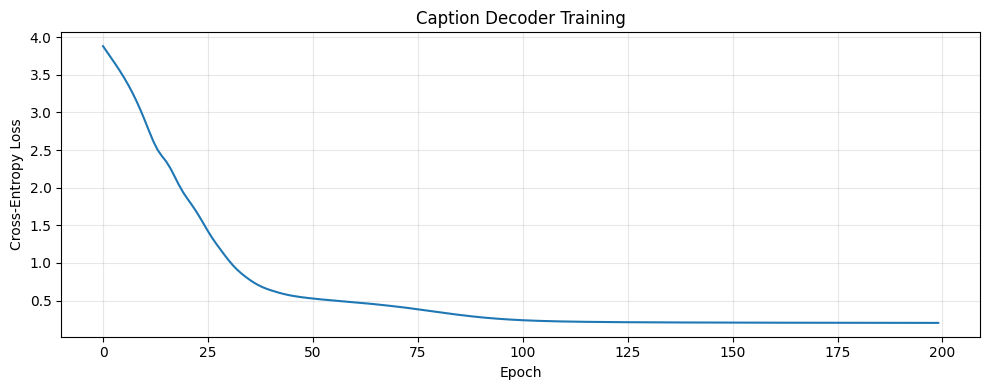

In [9]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title('Caption Decoder Training')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 7. Generate Captions

Let's test our trained decoder on the training images (and see if it generalizes).


In [10]:
# Generate captions for training images
print("Generated Captions vs Ground Truth:")
print("=" * 60)

# Get unique images (first caption of each image)
unique_images = []
seen_urls = set()
for i, item in enumerate(toy_data):
    if item["url"] not in seen_urls:
        seen_urls.add(item["url"])
        unique_images.append(i * 3)  # First caption index for each image

for idx in unique_images:
    sample = dataset[idx]
    # Convert to float32 to match decoder weights
    embedding = sample["embedding"].to(train_device).float()
    
    generated = decoder.generate(embedding, vocab)
    
    print(f"\nGround truth: \"{sample['caption']}\"")
    print(f"Generated:    \"{generated}\"")


Generated Captions vs Ground Truth:

Ground truth: "a cat with orange fur"
Generated:    "a cat with orange fur"

Ground truth: "a happy dog running"
Generated:    "a friendly dog outside"

Ground truth: "a beautiful tropical beach"
Generated:    "a beautiful tropical beach"

Ground truth: "a delicious breakfast plate"
Generated:    "a delicious breakfast plate"

Ground truth: "a city skyline at dusk"
Generated:    "a city skyline at dusk"


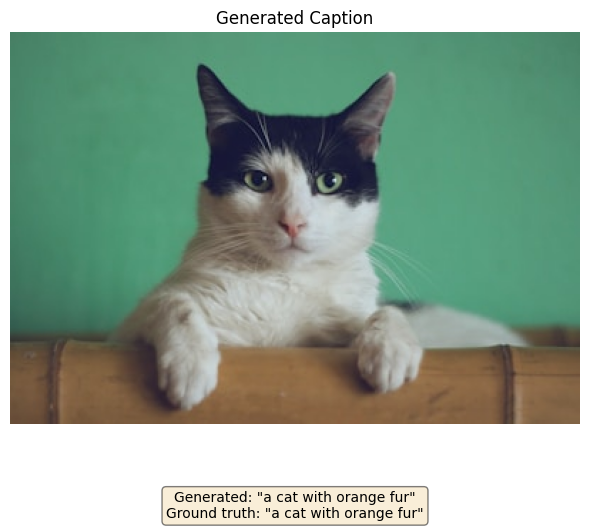

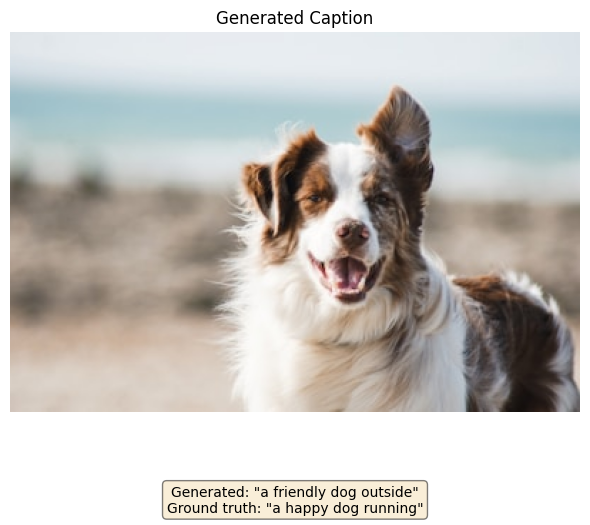

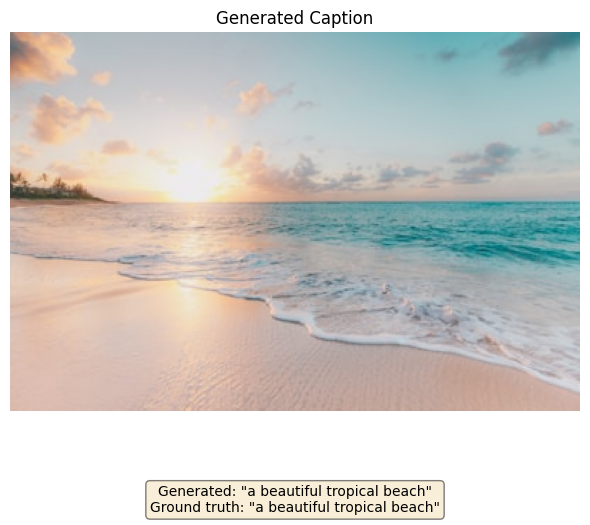

In [11]:
# Visualize generated captions
def show_with_caption(image, generated_caption, ground_truth):
    """Display image with generated and ground truth captions."""
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image)
    ax.axis('off')
    ax.set_title("Generated Caption", fontsize=12)
    
    text = f'Generated: "{generated_caption}"\nGround truth: "{ground_truth}"'
    plt.figtext(0.5, 0.02, text, wrap=True, horizontalalignment='center', 
                fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    plt.tight_layout()
    plt.show()

# Show a few examples
for idx in unique_images[:3]:
    sample = dataset[idx]
    embedding = sample["embedding"].to(train_device).float()
    generated = decoder.generate(embedding, vocab)
    show_with_caption(sample["image"], generated, sample["caption"])


## 8. Summary

In this notebook, we built a complete image captioning pipeline:

1. **CLIP as Image Encoder**: Used frozen CLIP embeddings as input features
2. **Vocabulary**: Built a simple word-level tokenizer
3. **LSTM Decoder**: Trained a decoder to generate captions word-by-word
4. **Greedy Generation**: Generated captions using argmax at each step

**Key Insights:**
- CLIP provides semantic image features that capture "what's in the image"
- The decoder learns to map these features to natural language
- This is a simplified version of how models like BLIP and Flamingo work

**Limitations of this toy example:**
- Very small dataset (15 samples) - would overfit on real data
- Simple LSTM decoder - modern systems use Transformers
- Greedy decoding - beam search would produce better results
- Word-level tokens - subword tokenization is more robust


## 9. Exercises

Try these to deepen your understanding:

1. **Beam Search**: Implement beam search decoding instead of greedy decoding. Does it improve caption quality?

2. **Attention**: Add an attention mechanism over image regions (using CLIP patch embeddings instead of the global embedding).

3. **Larger Dataset**: Download a subset of Flickr8k or COCO captions and train on more data.

4. **Transformer Decoder**: Replace the LSTM with a Transformer decoder.

5. **Evaluation Metrics**: Implement BLEU score to quantitatively evaluate caption quality.
